<a href="https://colab.research.google.com/github/viraj0112/GAN/blob/main/OUTPUT_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import datetime

from google.colab.patches import cv2_imshow

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, hr_name, lr_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.hr_name = hr_name+"/"
        self.lr_name = lr_name+"/"

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        Data_Dir = self.dataset_name #show contain hr and lr folder inside
        Data_Dir = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
        imgs_in_dir = [f for f in listdir(Data_Dir + self.hr_name) if isfile(join(Data_Dir + self.hr_name, f))]

        batch_images = np.random.choice(imgs_in_dir, size=batch_size)

        imgs_hr = []
        imgs_lr = []
        for img_path in batch_images:
            # print(img_path)
            img_hr = self.imread(Data_Dir+self.hr_name+img_path)
            img_lr = self.imread(Data_Dir+self.lr_name+img_path)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

            # print(imgs_hr)

        imgs_hr = np.array(imgs_hr) / 255
        imgs_lr = np.array(imgs_lr) / 255

        return imgs_hr, imgs_lr


    def load_predict_data(self,path, is_testing=False):
        data_type = "train" if not is_testing else "test"

        # Data_Dir = self.dataset_name #show contain hr and lr folder inside
        # Data_Dir = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
        # imgs_in_dir = [f for f in listdir(Data_Dir + self.hr_name) if isfile(join(Data_Dir + self.hr_name, f))]

        # batch_images = np.random.choice(imgs_in_dir, size=batch_size)

        imgs_lr = []
        # for img_path in batch_images:
            # print(img_path)
        img_lr = self.imread(path,True)

        imgs_lr.append(img_lr)

            # print(imgs_hr)

        imgs_lr = np.array(imgs_lr) / 255

        return imgs_lr

    def imread(self, path, predict = False):
      img = cv2.resize(cv2.imread(path), self.img_res)
      # cv2_imshow(img)
      # img  = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      # import matplotlib.pyplot as plt
      # plt.imshow(img)
      return img

In [ ]:
def PSNR(*args):#original, compressed):
  from math import log10, sqrt
  # print(args)
  mse = np.mean((args[0] - args[1]) ** 2)
  if(mse == 0):  # MSE is zero means no noise is present in the signal .
                # Therefore PSNR have no importance.
      return 100
  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse))
  return psnr

def mse(img1, img2):
   mse = ((img1- img2) ** 2).mean()
   return mse

In [ ]:
def build_generator(inp):

  def residual_block(layer_input, filters):
      """Residual block described in paper"""
      d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
      d = Activation('relu')(d)
      d = BatchNormalization(momentum=0.8)(d)
      d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
      d = BatchNormalization(momentum=0.8)(d)
      d = Add()([d, layer_input])
      return d

  def deconv2d(layer_input):

      """Layers used during upsampling"""
      u = Conv2D(256, kernel_size=3, strides=1, padding='same')(layer_input)
      u = UpSampling2D(size=1)(u)
      u = Activation('relu')(u)
      return u

  # Low resolution image input
  img_lr = inp


  # Pre-residual block
  c1 = Conv2D(256, kernel_size=9, strides=1, padding='same')(img_lr)
  c1 = Activation('relu')(c1)

  # Propogate through residual blocks
  r = residual_block(c1, 256)
  for _ in range(12 - 1):
      r = residual_block(r, 256)

  # Post-residual block
  c2 = Conv2D(256, kernel_size=3, strides=1, padding='same')(r)
  c2 = BatchNormalization(momentum=0.8)(c2)
  c2 = Add()([c2, c1])

  # Upsampling
  u1 = deconv2d(c2)
  u2 = deconv2d(u1)

  # Generate high resolution output
  gen_hr = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

  return Model(img_lr, gen_hr)

In [ ]:
modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/Model/Model300*300.h5"
dataset_name = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
hr_folder_name = "high_res"
lr_folder_name = "low_res"

model = load_model(modelPath)
# model.layers.pop(-1)
model.summary()

old_weights = model.get_weights()
# old_weights


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 300, 300, 25  62464       ['input_4[0][0]']                
                                6)                                                                
                                                                                                  
 activation (Activation)        (None, 300, 300, 25  0           ['conv2d_4[0][0]']               
                                6)                                                          

(1, 300, 300, 3)
HR


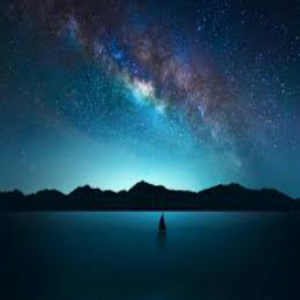

LR


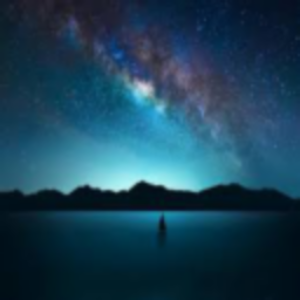

1/1 [==============================] - 37s 37s/step


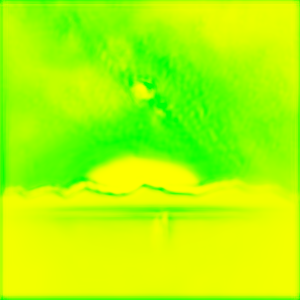

PSNR -> high : generated  ==> 48.36414947035797
MSE -> high : generated  ==> 0.9476880706593148


In [ ]:
y = DataLoader(dataset_name=dataset_name,hr_name=hr_folder_name,lr_name=lr_folder_name,img_res=(300,300)).load_data(1)
# print(y)
print(y[0].shape)
print("HR")
y1 = y[0][0]*255
# y1 = cv2.resize(y1,(256,256))
cv2_imshow(y1)
print("LR")
y2 = y[1][0]*255
# y2 = cv2.resize(y2,(256,256))
cv2_imshow(y2)
# model.compile(loss='binary_crossentropy',
#             optimizer=Adam(0.0001, 0.9),
#             metrics=['accuracy'])
modelNew= build_generator(Input(batch_shape=y[1].shape))
# modelNew.summary()
modelNew.set_weights(old_weights)
x = modelNew.predict(y[1])
x1 = x[0]*255
# x1 = cv2.resize(x1,(256,256))
cv2_imshow(x1)
print("PSNR -> high : generated  ==>",PSNR(y[0][0],x[0]))
print("MSE -> high : generated  ==>",mse(y[0][0],x[0]))

In [ ]:
# titles = ['Generated', 'Original']
# fig, axs = plt.subplots(2,2)
# cnt = 0
# for row in range(2):
#     for col, image in enumerate([x, y]):
#         axs[row, col].imshow(image[row])
#         axs[row, col].set_title(titles[col])
#         axs[row, col].axis('off')
#     cnt += 1
# fig.savefig("/content/xxxxxx.png")
# plt.imshow(fig)

1/1 [==============================] - 39s 39s/step


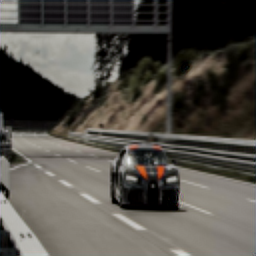

In [ ]:
y = DataLoader("","","").load_predict_data("/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/low_res/2.png")
y.shape

old_weights = model.get_weights()
# old_weights

modelNew= build_generator(Input(batch_shape=y.shape))
# modelNew.summary()

modelNew.set_weights(old_weights)
p = modelNew.predict(y)

# newModel.compile(loss='binary_crossentropy',
#             optimizer=Adam(0.0001, 0.9),
#             metrics=['accuracy'])


x1 = p[0]*255
# x1 = cv2.resize(x1,(256,256))
cv2_imshow(cv2.cvtColor(x1, cv2.COLOR_BGR2RGB))